### Importering av moduler

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from matplotlib import animation
import time

I dette prosjektet skal vi lage en modell av Vasa-skipet og utforske mulige årsaker til at det kantret. I prosjektet studerer vi et forenklet system der båten betraktes som en lang, halvsirkelformet båt med radius R, som vugger om en akse gjennom dens massesenter. Systemet skal først og fremst løses ved hjelp av numeriske metoder. Vi skal i hovedsak se på Eulers metode og Runge-Kutta 4 metoden. Mot slutten av prosjektet implementerer vi Bogacki-Shampine modellen som en tredje numeriske metode. Løpende i prosjektet så sammenligener vi metodene og ser på fordeler og ulempene ved dem.

In [63]:
# Massetetthet vann per lengdeenhet
sigma_0 = 1000 # kg/m^2
# Massetetthet skip per lengdeenhet 
sigma = 500 # kg/m^2
# Skipsradius
R = 10 # m
# Skips tverrsnittet
A_s = 1/2 * np.pi * R**2 # m^2
# Skipets masse per lengdeenhet
m = A_s * sigma # kg
# Høydeforskjell mellom metasenter og massesenter
h = 4 * R / (3 * np.pi) # m
# tyngends akselerasjon
g = 9.81
# Skiphets treghetsmoment
I_c = 1/2 * m * R**2 * (1 - 32/(9 * np.pi**2))

m_L = 0

In [64]:
def newtons_method_step(f, del_f, xn):
    # Returns x_n+1
    return xn - f(xn) / del_f(xn)

def newtons_method(f, del_f, x0, tol=1e-5, max_iter=10000):
    xn = x0
    for num_iter in range(max_iter):
        xn1 = newtons_method_step(f, del_f, xn)
        if np.abs(xn1 - xn) < tol:
            return xn1
        xn = xn1
    print("Newtons method:\nMax number of iterations exceeded")

I sin enkleste form blir skipets dynamikk kun beskrevet av dreiemomentene til tyngdekraften og oppdriftskraften om skipets metasenter M. Da blir skipets oppdriftkraft i likevekt gitt av arealet $A_0= \sigma \pi R^2/2\sigma_0$. Dette gir opphav til en sektorvinkel $\beta$ mellom vannlinjen på hver side av båten og metasenteret M, som  i Figure 2 ovenfor. Vinkelen $\beta$ brukes for å finne mengden fortrengt vann når båten er i likevekt. Denne sektorvinkelen blir bestemt av $A_0=\frac{1}{2}R^2(\beta- sin\beta)$. Det gir fikspunktslikningen:

$\begin{aligned} 
    \quad\quad\quad\quad\quad\quad\quad
    \beta - &sin(\beta) = \pi\sigma/
    \sigma_0 \\
    &\Downarrow \\
    \pi\sigma/\sigma_0 + &sin(\beta) - \beta = 0
\end{aligned}$

Vi har valgt å løse denne likningen med Newtons metode. Fikspunkt-metoden er også mulig å bruke i dette tilfellet. Derimot konvergerer Newtons metode kvadratisk, i motsetning til fikspunkt-metoden som konvergerer linerært. I tillegg er sannsynligheten for konvergens ved Newtons metode større for en tilfeldig valgt initialverdi. Dermed er Newtons metode foretrukket.

In [65]:
def beta_fixed(beta):
    return (np.pi * sigma / sigma_0) + np.sin(beta) - beta

def del_beta_fixed(beta):
    return np.cos(beta) - 1

beta_0 = newtons_method(beta_fixed, del_beta_fixed, 1)

def beta():
    return beta_0

print(f"β = {beta():.4f} rad")
print(f"β = {beta()*180/np.pi:.1f} grader")

β = 2.3099 rad
β = 132.3 grader


I store deler av prosjeket vil $\beta$ ha den samme verdien, som utregnet over. Senere kommer det til å å bli klart at det vil være nødvendig med en liten justering av dens verdi på grunn av inkludering av last på dekk.

Som en følge av den beregnede $\beta$ verdien, er det nå mulig å finne andre nyttige skipsparametre. Referansesystemet vi har valgt er y=0 til å være vannoverflaten, som marinstudentene ville kalt et "earth fixed referansesystem". Skipets metasenter er definert som punktet skipet roterer rundt i likevekt. I vårt tilfelle er metasenteret dekkets midtpunkt, og sentrum til vår halvsirkelformede skipsmodell. Høyden til metasenteret i likevekt blir da følgende:

$\begin{aligned}
    y_M^0 &= Rcos\beta/2 
\end{aligned}$

Skipets massesenter er tyngdepunktet til alle punktpartikler i modellen vår. Siden halvsirkelen er symmetrisk om y-aksen, vil massesenteret befinne seg på y-aksen. y-verdien til massesenteret for en kompakt halvsirkel er $h = 4R/3\pi \simeq 0.42 R$, da blir høyden til massesentert relativt vannoverflaten:

$\begin{aligned}
    y_C^0=y_M^0-h = Rcos\beta/2 - 4R/3\pi
\end{aligned}$

Skipets dypeste punkt vil alltid befinne seg på sirkelbuen, som er i en avstand R fra skipets metasenter. y-koordinaten til skipets dypeste punkt, vil da bli:

$\begin{aligned}
    y_D^0=y_M^0-R=Rcos\beta/2-R
\end{aligned}$

Det siste punktet som blir definert er angrepspunktet til oppdriftskraften til det fortrengte vannet på grunn av halvsirkelen. Oppdriftskrafta befinner seg egentlig i alle punkter der skipet er i kontakt med vannet. I alle disse punktene vil kraften virke normalt på skipsoverflaten, men på grunn av symmetrien til den delen av sirkelen som er under vannoverflaten, vil kreftene i x-retning utjevne hverandre, og den totale kraften vi kun ha en komponent i y-retning. Vi finner angrepspunktet til oppdriftskraften til å være:

$\begin{aligned}
    y_B^0=y_M^0-Y_{MB}^0=Rcos\beta/2-4Rsin^3(\beta/2)/3(\beta-sin\beta)
\end{aligned}$

Videre ønsker vi å definere oppdriftskrafta som det fortrengte vannet påfører Vasa-skipet. Ettersom det fortrengte arealet i første omgang er konstant, vil også oppdriftskrafta være konstant:

$\begin{aligned}
    F_B = A \sigma_0g
\end{aligned}$

Under definerer vi verdiene i kode, slik at de vil være tilgjengelig hvis nødvendig.

In [66]:
#høyden over metasenteret
y_M_0 = R * np.cos(beta()/2)
#høyden over massesenteret
def get_y_C_0():
    return  R * np.cos(beta()/2) - h
y_C_0 = y_M_0 - h
#avstanden fra M til B
Y_MB_0 = R * (4 * np.sin(beta()/2)**3)/(3 * (beta() - np.sin(beta())))
#høyden over oppdriftkraftens angrepspunkt 
y_B_0 = y_M_0 - Y_MB_0
#høyden over skipets dypeste punkt
y_D_0 = y_M_0 - R

In [67]:
A_0 = 0.5 * R**2*(beta() - np.sin(beta()))

def F_B0(t, w_vec): #F_B med konstant areal fortrengt
    return A_0 * sigma_0 * g #antar at mengden fortrengt vann er konstant i oppgave 1, slik at A -> A_0

def tau_B0(t, w_vec): #tau_B med konstant areal fortrengt 
    return -F_B0(t, w_vec) * h * np.sin(w_vec[0])

#tau_friction = friction * (y_C - (R * (np.cos(gamma / 2)) -1))
#tau_w = F_w * y_C
#tau_L = -m_L * g * np.cos(theta) * s_L

For å gjøre det enkelt i første omgang, velger vi å neglisjere alle krefter som virker på skipet, med unntak av tyngde- og oppdriftskraften. Hvis vi da i tillegg antar at mengden fortrengt vann ikke endrer seg, nemlig at $A \rightarrow A_0$, vil det da være mulig å se at $|F_G| = |F_B|$. Dette fører til at det er kun dreiemomentet $\tau_B$ som gjør at skipet beveger seg. Her har vi også måtte anta at massesenteres bevegelse er neglisjert.

Med disse antagelsene kan hele bevegelsen til skipet bli beskrevet av $\theta$ og $\dot{\theta}=\omega$. Dette kan vi samle i vektoren $\vec{\omega}(t) = \begin{bmatrix} \theta \quad  \omega \end{bmatrix}^{T}$. 

Bevegelsen vil være beskrevet av N2 rotasjon:

$\begin{aligned}
    \sum\tau    &= I_C \dot{\omega} \\
    \Rightarrow 
    I_C \dot{\omega} &= \tau_B = -F_Bhsin(\theta) \\
    \Rightarrow 
    \dot{\omega} &= -F_Bhsin(\theta)/I_C
\end{aligned}$

Alle verdiene som inngår i N2 rotasjon er gitt av t og $\theta$. 

$\begin{aligned}
    \frac{d\vec{\omega}}{dt}
    =   \frac{d}{dt}
        \begin{bmatrix}
            \theta \\
            \omega
        \end{bmatrix}
    =   \begin{bmatrix}
            \omega \\
            \dot{\omega}
        \end{bmatrix}
    =   \begin{bmatrix}
            \omega \\
            \sum\tau/I_C
        \end{bmatrix}
    =   \begin{bmatrix}
            \omega \\
            -F_Bhsin(\theta)/I_C
        \end{bmatrix}
\end{aligned}$

Siden vektoren over er en gitt av $\omega$, $\theta$ og t kan vi samle N2 rotasjon i en vektor.

$\begin{aligned}
    \Rightarrow \vec{f}(t,\vec{\omega}) = \frac{d\vec{\omega}}{dt}
\end{aligned}$

In [68]:
def f_oppgave_1C(t, w_vec):
    '''
    f_vec = [w, del_w]^T
    '''
    tau_array = np.array([tau_B0])
    f_vec = np.zeros(2)
    
    f_vec[0] = w_vec[1]
    f_vec[1] = np.sum([tau(t, w_vec) for tau in tau_array]) / I_c

    return f_vec

For å løse systemet ovenfor, behøver vi en Numerisk metode. Som utgangspunkt bruker vi Eulers metode. Metoden er en av de enklere og mest brukte, og krever kun et uttrykk for den deriverte og én funksjonsevalurering per steg. Den er en såkalt første ordens Runge-Kutta metode, noe som vil si at feilen minker proporsjonalt med steglengden. Metoden fungerer slik at vi deler intervallet opp i M like store delintervaller av lengden h, og tilnærmer funksjonen lineært ved hjelp av utrykket for den deriverte i hvert delintervall. Merk at vi i vår løsning kaller steglengden dt, istedenfor h. Et viktig poeng er at dersom vi bruker en veldig liten steglengde, så vil vi få mange funksjonsevalueringer. Det er derfor viktig å finne en steglengde som gir en liten feil, men som samtidig ikke gir for mange funksjonsevalueringer, da dette er lite effektivt ved kjøring av koden. Nedenfor er Eulers metode implementert for $\vec{\omega}$ og plottet for startverdiene $\theta(t=0)= 20^{\circ}$ og $\omega(t=0)= 0$, med tre forskjellige steg-lengder: 0.1, 0.01 og 0.001. 

In [69]:
def euler(f, t, wn, dt):
    # One step of the Euler method
    w_next = wn + dt*f(t, wn)
    t_next = t + dt
    return t_next, w_next

def ODE_solver(f, t0, tend, w0, dt, method = euler):
    '''
    Generic solver for ODEs
        y' = f(t,w), w(a)=w0
    Input: f, the integration interval t0 and tend, 
           the stepsize dt and the method of choice.  
       
    Output: Arrays with the t- and the corresponding w-values. 
    '''

    # Initialiserer:
    w_num = np.array([w0])    # Array for the solution w 
    t_num = np.array([t0])    # Array for the t-values

    tn = t0                # Running values for t and w
    wn = w0 

    # Main loop
    while tn < tend - 1.e-10:            # Buffer for truncation errors        
        tn, wn = method(f, tn, wn, dt)    # Do one step by the method of choice
        
        # Extend the arrays for t and w
        w_num = np.concatenate((w_num, np.array([wn])))
        t_num = np.append(t_num,tn)
    
    return t_num, w_num

Tid ved kjøring av dt= 0.001: 0.9592330455780029
Tid ved kjøring av dt= 0.0005: 3.6087589263916016


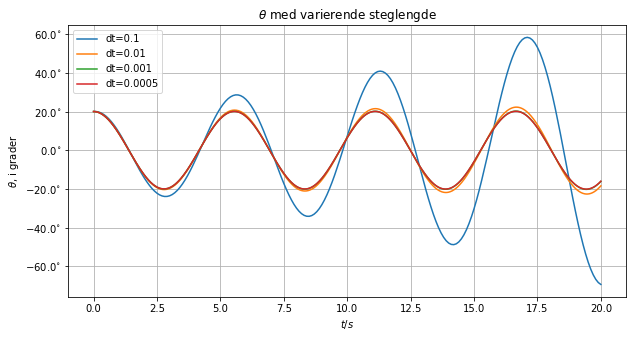

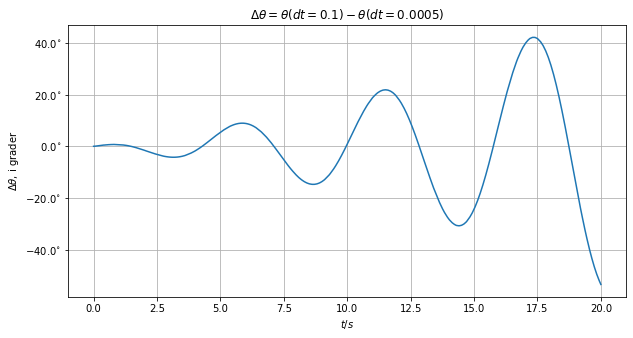

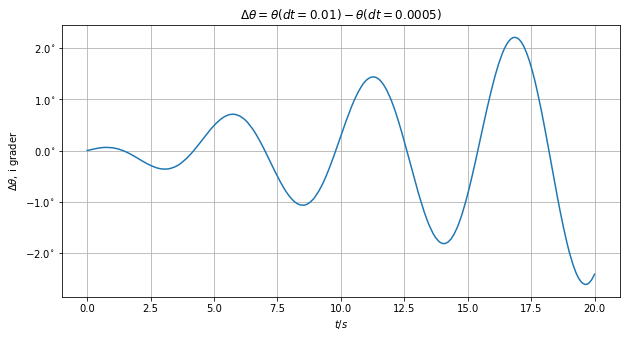

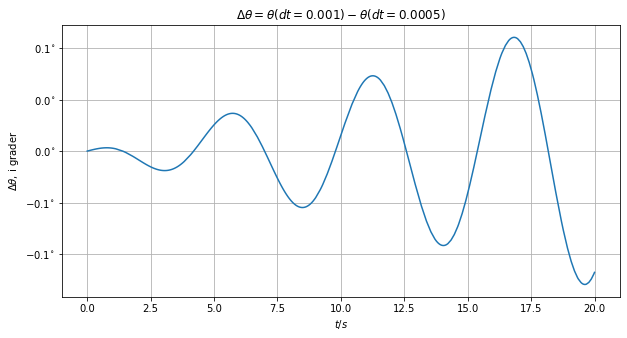

In [70]:
def get_f_vector(t, w_vec):
    return f_oppgave_1C(t, w_vec)

t0, tend = 0, 20
w0 = 0
theta0 = 20 *  np.pi/(180) # 20 grader, omgjort til radianer
w_vec = np.array([theta0, w0])

# Finne numeriske løsningen for w_vector med tre forskjellige steglengder
t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt= 0.1)
theta_num, w_num = np.transpose(w_vec_num)
theta_num = theta_num * 180 / np.pi

t_num_2, w_vec_num_2 = ODE_solver(get_f_vector, t0, tend, w_vec, dt=0.01)
theta_num_2, w_num_2 = np.transpose(w_vec_num_2)
theta_num_2 = theta_num_2 * 180 / np.pi

t_null = time.time()
t_num_3, w_vec_num_3 = ODE_solver(get_f_vector, t0, tend, w_vec, dt=0.001)
print(f'Tid ved kjøring av dt= 0.001: {time.time()-t_null}')
theta_num_3, w_num_3 = np.transpose(w_vec_num_3)
theta_num_3 = theta_num_3 * 180 / np.pi

t_null = time.time()
t_num_4, w_vec_num_4 = ODE_solver(get_f_vector, t0, tend, w_vec, dt=0.0005)
print(f'Tid ved kjøring av dt= 0.0005: {time.time()-t_null}')
theta_num_4, w_num_4 = np.transpose(w_vec_num_4)
theta_num_4 = theta_num_4 * 180 / np.pi


# Plotter den numeriske theta(t) 
plt.figure(1, figsize=(10,5))
plt.plot(t_num, theta_num, label='dt=0.1')
plt.plot(t_num_2, theta_num_2, label='dt=0.01')
plt.plot(t_num_3, theta_num_3, label='dt=0.001')
plt.plot(t_num_4, theta_num_4, label='dt=0.0005')
plt.legend()
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.grid()
plt.title(r"$\theta$ med varierende steglengde")

# Plotter differansen 
delta_theta_1 = np.interp(t_num_4, t_num, theta_num) - theta_num_4
delta_theta_2 = np.interp(t_num_4, t_num_2, theta_num_2) - theta_num_4
delta_theta_3 = np.interp(t_num_4, t_num_3, theta_num_3) - theta_num_4


plt.figure(2, figsize=(10,5))
plt.title(r'$\Delta\theta = \theta(dt=0.1) - \theta(dt=0.0005)$')
plt.plot(t_num_4, delta_theta_1)
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\Delta\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.grid()
plt.show()

plt.figure(3, figsize=(10,5))
plt.title(r'$\Delta\theta = \theta(dt=0.01) - \theta(dt=0.0005)$')
plt.plot(t_num_4, delta_theta_2)
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\Delta\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.grid()
plt.show()

plt.figure(4, figsize=(10,5))
plt.title(r'$\Delta\theta = \theta(dt=0.001) - \theta(dt=0.0005)$')
plt.plot(t_num_4, delta_theta_3)
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\Delta\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.grid()
plt.show()

Feilen mellom steglendene 0.01 og 0.001 er på sitt meste 2 grader. Selvom dette er en merkbar feil, så vil vi med steglengde 0.001 ha 10 ganger så mange funksjonsevalueringer som for 0.01. Med andre ord får vi en liten endring i feil til tross for betydelig antall flere evalueringer. Uansett vil ikke noen av disse steglengdene gi betydelig kjøretid, slik at steglengden 0.001 vil være god å bruke. Derimot, om vi senker steglengden ytterligere til for eksempel 0.0005, så vil kjøretiden øke betraktelig. Dette vil være et eksempel på en steglengde som er lite hensiktsmessig å bruke, spesielt om en tar i betrakning den minimale presisjonsforbedringen. På den andre enden av skalaen ser vi at en stor steglengde(her vist ved 0.1), gir store feil. Vi har med utgangspunkt i dette besluttet å bruke steglengde 0.001 med Eulers metode i kommende diskusjoner.

Istedenfor å bruke nummeriske metoder er det også vanlig i fysikk å bruke liten vinkel approksimasjon, som kan forenkle både likninger og differensialikninger. En slik approksimasjon vil for sinus-uttrykk være $sin\theta \approx \theta$, og gjelder for små vinkler $\theta$. En kan enkelt se at dette er en god approksimasjon for små vinkler dersom man plotter grafen til sinus. For små vinkler ($\theta$ nærme 0) så vil sinusgrafen være tilnærmet lineær, og lik funksjonen $y=\theta$. Fordelen med en slik approksimasjon er at den lar oss finne analytiske løsninger av for eksempel differensiallikninger, ettersom utrykket blir mindre komplekst. Dermed trenger man ikke belage seg på diverse numeriske metoder:

$\begin{aligned}
    -mgh\tilde{\theta} &= I_C \ddot{\theta}\\
    \Rightarrow \vec{f}_{\sim}(t, \vec{\omega}) &=  \begin{bmatrix}
                                \tilde{\omega} \\
                                -mgh\tilde{\theta}/I_C
                            \end{bmatrix}
\end{aligned}$
 
For å ikke ta noe for gitt ønsker vi å undersøke hvor god denne tilnærmingen faktisk er for ulike initialbetingelser. Under har vi plottet den numeriske løsningen av problemet med og uten liten vinkel approksimasjon. Dette har blitt gjort i to omganger, der vi først har brukt initialverdi $\theta = 20$, og i andre omgang $\theta = 1$. 


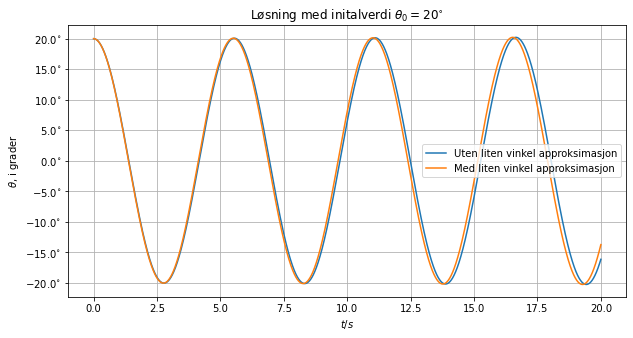

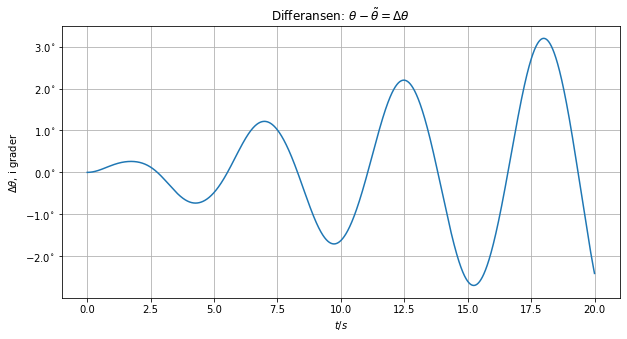

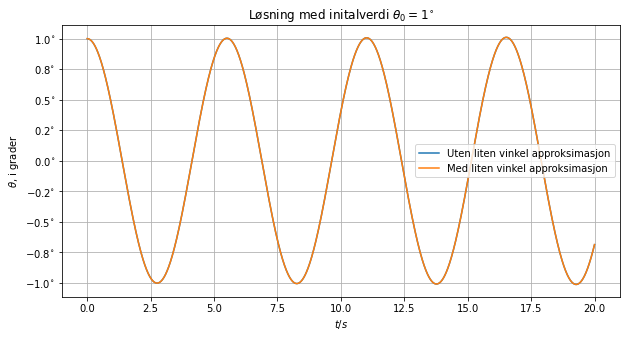

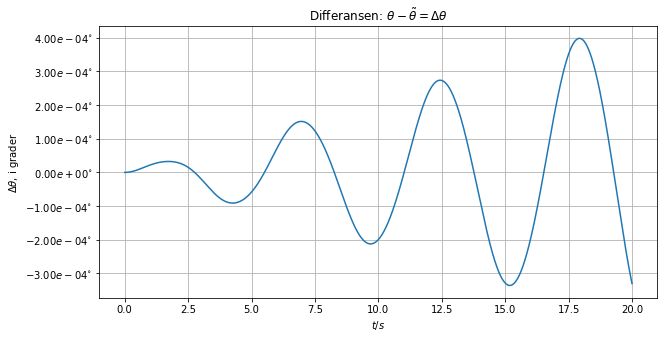

In [71]:
def small_angle_f(t, w_vec):
    return np.array([w_vec[1], -m*g*h*w_vec[0]/I_c])

def get_f_vector(t, w_vec):
    return f_oppgave_1C(t, w_vec)

t0, tend = 0, 20
w0 = 0
theta0 = 20 *  np.pi/(180) # 1 grader, omgjort til radianer
w_vec = np.array([theta0, w0])
dt = 0.001

# Finne numeriske løsningen for w_vector, med liten vinkel approksimasjon
t_num, w_vec_tilde = ODE_solver(small_angle_f, t0, tend, w_vec, dt)
theta_tilde, w_tilde = np.transpose(w_vec_tilde)
theta_tilde = theta_tilde * 180 / np.pi

# Finne numeriske løsningen for w_vector, uten liten vinkel approksimasjon
t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt)
theta_num, w_num = np.transpose(w_vec_num)
theta_num = theta_num * 180 / np.pi

#print(theta_num)


# Plotter den numeriske theta(t), med og uten liten vinkel approksimasjon
plt.figure(1, figsize=(10,5))
plt.plot(t_num, theta_num, label="Uten liten vinkel approksimasjon")
plt.plot(t_num, theta_tilde, label="Med liten vinkel approksimasjon")
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.title(r"Løsning med initalverdi $\theta_{0} = 20^{\circ}$")
plt.grid()
plt.legend()
plt.show()

# Plotter differansen 
plt.figure(2, figsize=(10,5))
plt.title(r"Differansen: $\theta - \tilde{\theta} = \Delta\theta$")
plt.plot(t_num, theta_num - theta_tilde)
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\Delta\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.grid()
plt.show()

theta0_1 = 1 *  np.pi/(180) # 1 grader, omgjort til radianer
w_vec_1 = np.array([theta0_1, w0])
# Finne numeriske løsningen for w_vector, med liten vinkel approksimasjon
t_num_1, w_vec_tilde_1 = ODE_solver(small_angle_f, t0, tend, w_vec_1, dt)
theta_tilde_1, w_tilde_1 = np.transpose(w_vec_tilde_1)
theta_tilde_1 = theta_tilde_1 * 180 / np.pi

# Finne numeriske løsningen for w_vector, uten liten vinkel approksimasjon
t_num_1, w_vec_num_1 = ODE_solver(get_f_vector, t0, tend, w_vec_1, dt)
theta_num_1, w_num_1 = np.transpose(w_vec_num_1)
theta_num_1 = theta_num_1 * 180 / np.pi

# Plotter den numeriske theta(t), med og uten liten vinkel approksimasjon
plt.figure(3, figsize=(10,5))
plt.plot(t_num_1, theta_num_1, label="Uten liten vinkel approksimasjon")
plt.plot(t_num_1, theta_tilde_1, label="Med liten vinkel approksimasjon")
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.1f}^{\circ}$'))
plt.title(r"Løsning med initalverdi $\theta_0 = 1^{\circ}$")
plt.grid()
plt.legend()
plt.show()

# Plotter differansen 
plt.figure(4, figsize=(10,5))
plt.title(r"Differansen: $\theta - \tilde{\theta} = \Delta\theta$")
plt.plot(t_num, theta_num_1 - theta_tilde_1)
plt.xlabel(r"$t/s$")
plt.ylabel(r"$\Delta\theta$, i grader")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter(r'${%.2e}^{\circ}$'))
plt.grid()
plt.show()


Ved å studere grafen som angir feilen gitt av differansen mellom med og uten approksimasjonen kan vi vurdere hvor god approksimasjonen er. For $\theta_0 = 1^\circ$, ser en at feilen i intervallet er av størrelsesorden $10^{-4}$ grader, som er meget lite. I tillegg er det ikke mulig å skille de to løsningene fra hverandre dersom en studerer plottet med og uten liten vinkel approksimasjon. Det kan dermed konkluderes med at dette er en god approksimasjon for små vinkler. På den andre siden vil $\theta_0 = 20^\circ$, gi en markant feil, som kan bli så stor som $3^{\circ}$. I tilfellet med en relativt stor startvinkel vil dermed en slik approksimasjon være dårlig. Det er derfor ikke feil å benytte seg av approksimasjonen, men da må det forventede utslaget av $\theta$ vurderes.

Fram til nå har vi benyttet Eulers metode for å finne en numerisk løsning av systemet. Nå ønsker vi derimot å utforske en annen metode, nemlig Runge-Kutta 4 metoden.

Runge-kutta 4 (vil bli referert som RK4) er også en mye brukt numerisk metode, og foretrekkes over Eulers metode når presisjon er et ønske. Det vil si at det for RK4 trengs færre delintervaller for å gi en god løsning av systemet. I tillegg til å være av fjerde orden, er metoden relativt enkel å implementere. Metoden evaluerer funksjonen $f$ 4 ganger for hvert steg, gitt ved $K_1$ til og med $K_4$. Funksjonen $f$ er her et uttrykk for den deriverte. Disse funksjonsevalueringene gir grunnlag for å regne ut det neste steget i den numeriske tilnærmingen. Dette repeteres inntil vi har nådd slutten av det gitte intervallet. Vi skal snart se på en sammenlikning av de to metodene. 

In [72]:
def RK4(f, tn, wn, dt):

    k1 = f(tn, wn)
    k2 = f(tn + dt/2, wn + dt * k1/2)
    k3 = f(tn + dt/2, wn + dt * k2/2)
    k4 = f(tn + dt/2, wn + dt * k3)

    w_next = wn + dt/6*(k1+2*k2+2*k3+k4)
    t_next = tn + dt

    return t_next, w_next 

Fra teorien vet vi at RK4 er en metode av fjerde orden, i motsetning til Eulers metode som er av første orden. Det gir at den globale feilen til RK4 er av orden O($h^4$), der feilen ved Eulers metode er av orden O(h). Dette kommer vi snart til å undersøke.

Før den tid må vi finne en måte å beregne feilen til metodene. Feilen er lett å finne dersom man har en analytisk løsning. Her kan vi få bruk for liten vinkel approksimasjonen. For små vinkler har vi sett at liten vinkel approksimasjon gir neglisjerbar feil, og det er derfor rimlig å bruke den analytiske løsningen gitt av den som en god tilnærming til den sanne analytike løsningen. Differensiallikningen velger vi løse med Laplacetransformasjoner, siden det har en ganske rett fram fremgangsmåte.

La $\mathscr{L}[\tilde\theta] = \tilde\Theta$ og $k^2 = \frac{mgh}{I_C}$:

$\begin{aligned}
    \ddot{\tilde{\theta}} + k^2\tilde\theta &= 0 \\
    \mathscr{L}[\ddot{\tilde\theta} + k^2\tilde\theta] &= 0 \\
    s^2\tilde\Theta - s\tilde\theta_0 - \omega_0 + k^2\tilde\Theta&= 0 \\
    \tilde\Theta(s^2 + k^2) &= \omega_0 + s\theta_0 \\
    \tilde\Theta &= \frac{\omega_0 + s\theta_0}{s^2 + k^2} \\\\
    \Rightarrow \tilde\theta(t) = \frac{\omega_0}{k}sin(kt) + \theta_0cos(kt)
\end{aligned}$

In [73]:
def analytic_small_angle(t, theta0, w0):
    k = np.sqrt(m*g*h/I_c)
    return w0/k * np.sin(k*t) + theta0 * np.cos(k*t)

Nå er vi klar for å underøke feilen og ordenen til metodene våre:

$\begin{aligned}
    e(h) &= |\theta_{num} - \theta_{analytisk}| \approx |\theta_{num} - \tilde{\theta}_{analytisk}| = \tilde{e}(h)
\end{aligned}$

For Runge Kutta metoder forventer vi at feilen har en øvre grense gitt av steglengden, ordenen og en konstant. 

$\begin{aligned}
    \tilde{e}(h) \approx e(h) &\leq Ch^p \\
\end{aligned}$

Hvis vi plotter feilen med logaritmisk x og y akse forventer vi at plottet blir tilnærmet lineært med stigningstall lik ordenen til metoden.

$\begin{aligned}
    \tilde{e}(h) &\lessapprox Ch^p \\
    \Rightarrow ln(e(h)) &\lessapprox p\cdot ln(h) + ln(C) \\
    \Rightarrow y &\approx p \cdot x + C'
\end{aligned}$

Ved å plotte feilen logaritmisk for $t=20$ som funksjon av steglengden kan vi anslå ordenen til RK4 og Eulers metode, med liten $\theta_0$ og feilen gitt av den analytiske løsningen for liten vinkel approksimasjonen.

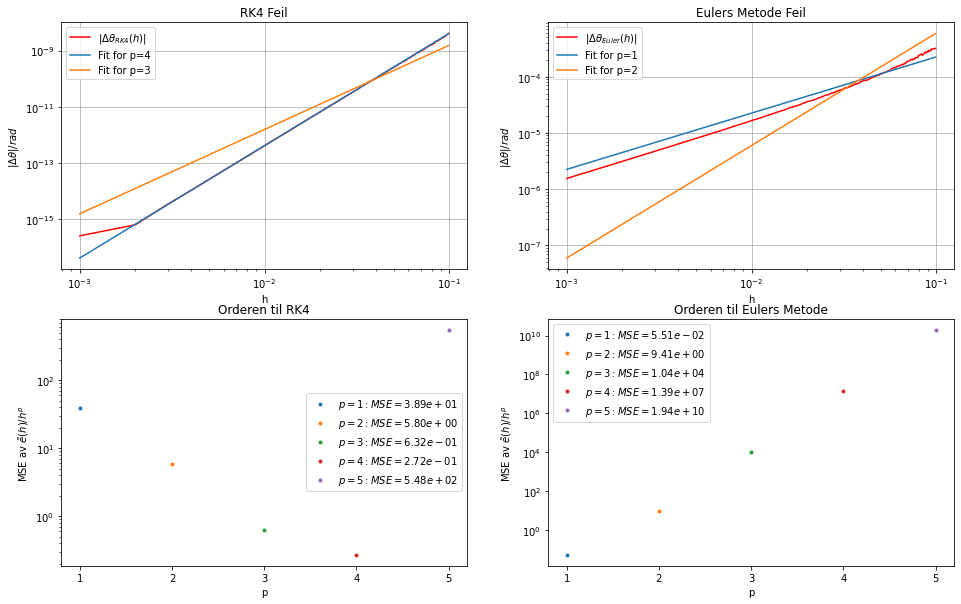

In [74]:
def check_order(xdata, ydata, ax):
    p_values = np.arange(1, 6, dtype=int)
    C_values = np.zeros_like(p_values, dtype=float)
    for i, p in enumerate(p_values):
        def lin_func(x, C):
            return p*x + C
        popt, pcov = curve_fit(lin_func, np.log(xdata), np.log(ydata))
        C = np.exp(popt[0])
        mse = np.mean((1 - ydata/(C*xdata**p))**2)
        ax.plot(p, mse, ".", label=r"$p = %.0f: MSE = %.2e$" % (p, mse))
        C_values[i] = C
    ax.set_ylabel(r"MSE av $\tilde{e}(h)/h^{p}$")
    ax.set_xlabel("p")
    ax.set_xticks(p_values)
    ax.set_yscale('log')
    ax.legend()

    return p_values, C_values

def get_f_vector(t, w_vec):
    return f_oppgave_1C(t, w_vec)

t0, tend = 0, 20
w0 = 0
theta0 = 0.01 *  np.pi/(180) # 1 grader, omgjort til radianer

dt_values = np.arange(0.001, 0.1, step=0.001)

delta_theta = np.zeros((2, np.shape(dt_values)[0]))

for i, dt in enumerate(dt_values):
    w_vec = np.array([theta0, w0])

    # Finner numeriske løsningen for w_vector, med liten vinkel approksimasjon og RK4
    t_num, w_vec_rk4 = ODE_solver(small_angle_f, t0, tend, w_vec, dt, method=RK4)
    theta_num_RK4 = w_vec_rk4[:,0]

    # Finner numeriske løsningen for w_vector, med liten vinkel approksimasjon og euler
    t_num, w_vec_euler = ODE_solver(small_angle_f, t0, tend, w_vec, dt, method=euler)
    theta_num_euler = w_vec_euler[:,0]

    # Finner analytisk løsning
    theta_analytic = analytic_small_angle(t_num, theta0, w0)

    delta_theta[0,i] = np.abs(theta_analytic - theta_num_RK4)[-1]
    delta_theta[1,i] = np.abs(theta_analytic - theta_num_euler)[-1]



plt.subplots(2,2, figsize=(16,10))

# Plotter differansen 
ax = plt.subplot(2,2,1)
ax.set_title(r"Differansen: $|\theta_{analytic} - \theta_{RK4}|=|\Delta\theta_{Rk4}|$")
ax.plot(dt_values, delta_theta[0], "r", label=r"$|\Delta\theta_{RK4}(h)|$")
ax.set_xlabel("h")
ax.set_ylabel(r"$|\Delta\theta|/rad$")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("RK4 Feil")
ax.grid()

ax1 = plt.subplot(2,2,3)
p_values, C_values = check_order(dt_values, delta_theta[0], ax1)
ax1.set_title("Orderen til RK4")

# ax.plot(dt_values, C_values[4]*dt_values**5, label=f"Fit for p=5")
ax.plot(dt_values, C_values[3]*dt_values**4, label=f"Fit for p=4")
ax.plot(dt_values, C_values[2]*dt_values**3, label=f"Fit for p=3")
ax.legend()


# Plotter differansen 
ax = plt.subplot(2,2,2)
ax.set_title(r"Differansen: $|\theta_{analytic} - \theta_{Euler}|=|\Delta\theta_{Euler}|$")
ax.plot(dt_values, delta_theta[1], "r", label=r"$|\Delta\theta_{Euler}(h)|$")
ax.set_xlabel("h")
ax.set_ylabel(r"$|\Delta\theta|/rad$")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Eulers Metode Feil")
ax.grid()


ax1 = plt.subplot(2,2,4)
p_values, C_values = check_order(dt_values, delta_theta[1], ax1)
ax1.set_title("Orderen til Eulers Metode")


ax.plot(dt_values, C_values[0]*dt_values**1, label=f"Fit for p=1")
ax.plot(dt_values, C_values[1]*dt_values**2, label=f"Fit for p=2")
ax.legend()


plt.show()

Over har vi plottet feilen som funksjon av steglengden for RK4 og Eulers metode slik vi diskuterte. Ved hjelp av scipy.optimize.curve_fit fant vi lineære funksjoner som var nærmest feilen. $\: ln[\tilde{e}](ln(h)) \approx px + C'$ for heltalls verdier av p mellom 1 og 5. Fra de øverste plottene virker det klart at orden eller p lik 4 og 1 for henholdsvis RK4 og Eulers metode gir best tilnærming. Ved å se på "mean square error" for lineær tilnærmingene for p verdiene, understreker dette poenget. På nederste plottene er MSE lavest for orden 4 og 1 for henholdsvis RK4 og Eulers metode. Med dette konkluderer vi at ordene til RK4 og Eulers metode er henholdsvis 4 og 1, som stemmer med hva vi forventer fra teorien.

Det mest kritiske å legge merke til her blir klart at RK4 har flere størrelseordner mindre feil enn Eulers metode for enhver steglengde. Fremover vil vi derfor bruke RK4 istedenfor Eulers metode, og med steglengden $h=0.01$. Dette kan begrunnes ved at vi tidligere har sett på feilen til Eulers metode, og fra plottene ser vi at RK4 har betydelig lavere feil med $h=0.01$ enn hva vi krevde tidligere fra Eulers metode da vi brukte $h = 0.001$.

Frem til nå har vi sett på et relativt enkelt system der mengden fortrengt areal har vært konstant, og hvor en rekke krefter har blitt neglisjert. I løpet av denne delen av prosjektet ønsker vi å gradvis legge til flere momenter slik at vi får et relativt mer realistisk system enn det vi har sett på til nå. Dette vil innebære å se på hvordan massesenteret til skipet endrer seg. Dette blir innført og modellert ved å legge til parametrene $y, v_y, x, v_x$ som beskriver posisjon og hastighet for massesenteret.

Dette ønsker vi å inkludere i omega-vektoren slik at vi får løst det nye systemet. Dette er gjort nedenfor. 


$\begin{aligned}
    \vec{\omega} = 
        \begin{bmatrix}
            \theta \\
            \omega \\
            y \\
            v_y \\
            x \\
            v_x
        \end{bmatrix} \\
    \Rightarrow \vec{f}(t,\vec{\omega}) = \frac{d}{dt}\vec{\omega} = 
        \begin{bmatrix}
            \omega \\
            \sum\tau/I_C \\
            v_y \\
            \sum F_y/m  \\
            v_x \\
            \sum F_x/m 
        \end{bmatrix} \\
\end{aligned}$

På samme vis som for dreiemomentene, summerer vi opp de ulike kreftene i x og y-retning samt de nye dreiemomentene hver for seg, og legger dette til i f-vektoren. Dermed ender vi opp med en ny f-vektor, på samme form som tidligere.

I første omgang skal vi studere hva som skjer når vi lar arealet av fortrengt vann variere. For at mengden fortrengt areal skal kunne variere i systemet, må vinkelen gamma implementreres. Gamma beskriver vinkelen  mellom vannlinjen på hver side av båten og metasenteret M. Gamma beskriver altså den samme vinkelen som beta, men varierer nå ettersom båten gynger og at massesenteret forflytter seg i forhold til vannlinja. Vi forenklet det oppgitte uttrykket for gamma til å bli:

$\begin{aligned}
    \gamma = 2 \cdot \arccos\left(\frac{4}{3\pi} cos(\theta) + y_C/R\right)
\end{aligned}$

Arealet av fortrengt vann har som sagt vært konstant fram til nå. Det medfører at oppdriftskrafta og gravitasjonskrafta har kansellert hverandre, slik at kun oppdriftkraftas dreiemoment ga opphav til gynging.  Derimot vil et varierende areal gi en oppdriftskraft F_B som også varierer slik at dette ikke lenger er tilfellet. Dermed må koden vår ta hensyn til disse kreftene. I kodeblokka under har vi implementert de nevnte endringene i systemet.

In [75]:
def gamma(w_vec):
    return 2*np.arccos(4/(3*np.pi) * np.cos(w_vec[0]) + w_vec[2]/R)

def get_A(w_vec):
    A = 0.5 * R**2*(gamma(w_vec) - np.sin(gamma(w_vec)))

    return A

def F_B(t, w_vec): 
    return get_A(w_vec) * sigma_0 * g

def F_G(t, w_vec):
    return -m*g

def tau_B(t, w_vec): 
    return -F_B(t, w_vec) * h * np.sin(w_vec[0])

def f_oppgave_2A(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x]^T
    '''
    tau_array = np.array([tau_B])
    Fy_array = np.array([F_G, F_B])
    Fx_array = np.array([])
    f_vec = np.zeros_like(w_vec)
    
    f_vec[0] = w_vec[1]
    f_vec[1] = np.sum([tau(t, w_vec) for tau in tau_array]) / I_c
    f_vec[2] = w_vec[3]
    f_vec[3] = np.sum([Fy(t, w_vec) for Fy in Fy_array])/m
    f_vec[4] = w_vec[5]
    f_vec[5] = np.sum([Fx(t, w_vec) for Fx in Fx_array])/m

    return f_vec

Med alle endringene ovenfor implementert, er vi nå klare for å se på hvordan vinkelen $\theta$ og avstanden $y_C$ utvikler seg med tiden. Vi starter med å se på et system med følgende initialverdier: $\omega(t=0) = 0, \theta(t=0) = 20^\circ, y(t=0) = y_C^0, x(t=0) = v_x(t=0) = v_y(t=0) = 0$ og steglengde $dt = 0.01$.  

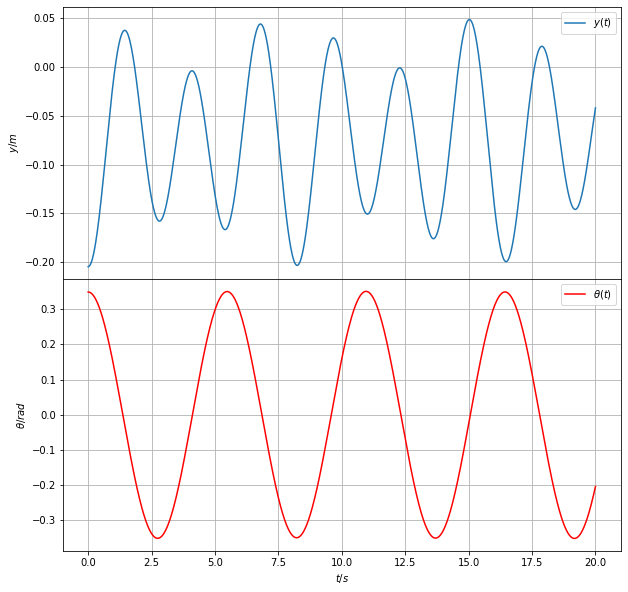

In [76]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x]^T
    '''
    return f_oppgave_2A(t, w_vec)

m_L = 0

t0, tend = 0, 20
w0 = 0
theta0 = 20 *  np.pi/(180) # 20 grader, omgjort til radianer
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
v_vec = np.array([theta0, w0, y0, vy0, x0, vx0])
dt = 0.01

# Finne numeriske løsningen for w_vector
t_num, vec_values = ODE_solver(get_f_vector, t0, tend, v_vec, dt, method=RK4)
y_num = vec_values[:,2]
vy_num = vec_values[:,3]
theta_num = vec_values[:,0]


plt.subplots(2, 1, figsize=(10,10), gridspec_kw={"height_ratios":[1,1]}, sharex="col")
plt.subplots_adjust(hspace=0)

# Plotter den numeriske y(t)
ax = plt.subplot(2, 1, 1)
ax.plot(t_num, y_num, label=r"$y(t)$")
# plt.xlabel(r"$t/s$")
ax.set_ylabel(r"$y/m$")
ax.legend()
ax.grid()

# Plotter den numeriske theta(t) 
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, theta_num, "r", label=r"$\theta(t)$")
ax.set_xlabel(r"$t/s$")
ax.set_ylabel(r"$\theta/rad$")
ax.grid()
ax.legend()
plt.show()

Ettersom mengden fortrengt areal nå varier, vil også den nevnte avstanden $y_C$ variere. Det fotrengte arealet er en funksjon av $\gamma$, som fører til at det fortrengte arealet øker med utslaget til $\theta$. Dette er en mulig forklaring på de to ulike amplituden som $y_C$ varierer mellom. På den andre siden virker det som $\theta$ er mindre sensitiv til de nye endringene, som kan sees på hvor regelmessig plottet er i forhold til $y_C$

Videre ønsker vi å implementere at Vasa-skipet kan kantre. Kantring skal skje dersom dekket til skipet kommer i kontakt med vannlinja. Kriteriet for kantring er gitt ved $\theta > (\pi - \gamma)/2$. Når dette inntreffer setter vi alle verdiene til null, utenom $\theta$, som nå blir satt til  $\pm \pi/2$, avhengig av hvilken side båten kantrer på. Dette gjør at det tydelig vises når båten kantrer i plottene fremover.

I tillegg ønsker vi å finne minste verdi for $\omega(t=0)$ som gjør at Vasa-skipet kantrer. Vi finner et estimat for minste $\omega(t=0)$ ved å bruke en algoritme inspirert av halveringsmetoden. Grunnen til at vi har valgt halveringsmetoden er at det er en svært enkel metode å implementere som også er lett anvenlig til vår problemstilling. Ulempen med metoden er at den krever mange iterasjoner for å få et godt resultat, noe som gir lang kjøretid relativt resten av koden i prosjektet. Vi har gitt metoden en toleranse på 10^(-6), slik at vi får et godt estimat.

Kantring når: omega_0 ⪆ 0.43325233459472656


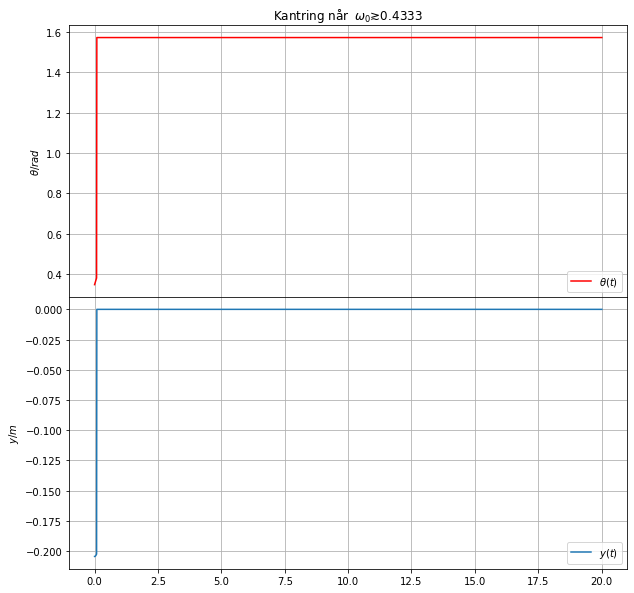

In [77]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x]^T
    '''
    return f_oppgave_2A(t, w_vec)

m_L = 0

def ODE_solver(f, t0, tend, w0, dt, method = euler):
    '''
    Generic solver for ODEs
        y' = f(t,w), w(a)=w0
    Input: f, the integration interval t0 and tend, 
           the stepsize dt and the method of choice.  
       
    Output: Arrays with the t- and the corresponding w-values. 
    '''

    # Initialiserer:
    w_num = np.array([w0])    # Array for the solution w 
    t_num = np.array([t0])    # Array for the t-values

    tn = t0                # Running values for t and w
    wn = w0 

    # Main loop
    while tn < tend - 1.e-10:            # Buffer for truncation errors        
        tn, wn = method(f, tn, wn, dt)    # Do one step by the method of choice
        if wn[0] > (np.pi - gamma(wn))/2: # If the ship capsizes
            wn[0] = np.sign(w_num[-1, 0]) * np.pi/2
            wn[1:] = 0
            for tn in np.arange(tn, tend+dt, dt):
                w_num = np.concatenate((w_num, np.array([wn])))
                t_num = np.append(t_num, tn)
            break   
        # Extend the arrays for t and w
        w_num = np.concatenate((w_num, np.array([wn])))
        t_num = np.append(t_num,tn)
    
    return t_num, w_num


def finn_minste_w0_kantring():
    t0, tend = 0, 20
    theta0 = 0 *  np.pi/(180) # 20 grader, omgjort til radianer
    y0 = get_y_C_0()
    vy0 = 0
    x0 = 0
    vx0 = 0
    v_vec = np.array([theta0, w0, y0, vy0, x0, vx0])
    dt = 0.01
    w0_ovre = 0.5 #verdi som vi vet gir kantring
    w0_nedre = 0 #verdi som ikke gir kantring
    
    tol = 1e-6
    while np.abs(w0_ovre - w0_nedre) > tol:
        c = (w0_ovre+w0_nedre)/2

        v_vec = np.array([theta0, c, y0, vy0, x0, vx0])
        t_num, vec_values = ODE_solver(get_f_vector, t0, tend, v_vec, dt, method=RK4)
        theta_num = vec_values[:,0]

        if abs(theta_num[-1]) == np.pi/2: #hvis den kantrer for w0_nedre
            w0_ovre = c 

        else:
            w0_nedre = c

    return w0_ovre 

w0_min = finn_minste_w0_kantring()
print(f"Kantring når: omega_0 ⪆ {w0_min}")
v_vec = np.array([theta0, w0_min, y0, vy0, x0, vx0])
t_num, vec_values = ODE_solver(get_f_vector, t0, tend, v_vec, dt, method=RK4)
theta_num = vec_values[:,0]
y_C_num = vec_values[:,2]

plt.subplots(2, 1, figsize=(10,10), gridspec_kw={"height_ratios":[1,1]}, sharex="col")
plt.subplots_adjust(hspace=0)

# Plotter den numeriske theta(t) 
ax = plt.subplot(2, 1, 1)
ax.set_title(r"Kantring når $\: \omega_0 \gtrsim %.4f$" % w0_min)
ax.plot(t_num, theta_num, "r", label=r"$\theta(t)$")
ax.set_xlabel(r"$t/s$")
ax.set_ylabel(r"$\theta/rad$")
ax.grid()
ax.legend()

# Plotter den numeriske y(t)
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, y_C_num, label=r"$y(t)$")
# plt.xlabel(r"$t/s$")
ax.set_ylabel(r"$y/m$")
ax.legend()
ax.grid()

plt.show()

Vi ser av plottene for minste $\omega(t=0)$, at kantring forekommer ved maksimal $\theta$ kombinert med at massesenteret er godt under vannlinja $y = 0$. Det er tydelig at dersom vi derimot ikke hadde hatt en endring i fortrengt areal ville ikke skipet ha kantret for denne verdien av $\omega(t=0)$. Posisjonen til massesenteret, og dermed den varierende mengden fortrengt vann, har derfor mye å si for om vi får kantring eller ikke.


Fram til nå har vi kun sett på et skip uten noen form for last. Vasa-skipet hadde naturligvis last på dekk, og er derfor noe vi ønsker å implementere i modellen vår. For å gjøre det lett å modellere antar vi at lasten er en punktmasse med masse $m_L$. Videre antar vi at de svenske seileren har glemt å feste lasten, som fører til at lasten beveger som fritt langs med skipsdekket. Hvis en ser bort i fra friksjon så vil kreftene som virker på lasten være normalkraften fra skipet og tyngdekraften. Siden vi antar ren horisontal bevegelse så forventer vi at tyngdekraften vertikalt relativt til dekket og normalkraften kanselleres, og at den eneste kraften vi har igjen er tyngdekrafts komponenten horisontalt til skipsdekket.

La $S_L$ betegne lastens posisjon relativt punktet M og la hastigheten være gitt av $v_L$. Med antagelsene over gir dette bevegelses ligningen gitt av N2 som følgende:

$\begin{aligned}
    \sum F_L &= m_L \dot{v_L} \\
    \Rightarrow F_{GL} &= m_L \dot{v_L} \\
    \Rightarrow F_{GL} &= m_L \dot{v_L} \\
    \Rightarrow -m_L g sin(\theta)  &= m_L \dot{v_L} \\
    \Rightarrow \dot{v_L}   &= g sin(\theta)\\
\end{aligned}$

Igjen så kan det sees at dette er en enkel ODE gitt av $t$ og $\theta$, som gir et koblet system av ODE-er.

Ved inkludering av lasten vil det også virke nye krefter på skipet, som vil gjøre at dette blir et system av koblede ODE-er. De nye kreftene på skipet som nå må inkluderes blir kontaktkraften i både x og y retning fra lasten. En annen betraktning som også nå må gjøres er at i likevekt vil det nå også virke en større tyngde som vil dytte skipet nedover. Denne tyngden vil bekskrives av $m \rightarrow m + m_L$, som vil føre til at en større mengde vann må fortrenges for å gi nok oppdriftekraft for å opprettholde likevekt. Dette vil føre til at $y_C^0$ vil være mer under vannoverflaten enn tidligere og vil føre til at likevektsvinkelen $\beta$ får en annen verdi. Vi har valgt å se på dette som at vekten til lasten blir fordelt jevnt på hele skipets areal.

$\begin{aligned}
    \beta - sin(\beta) = \pi \frac{\sigma}{\sigma_0}
    \rightarrow
    \beta - sin(\beta) = \pi \frac{\sigma + m_L / A_S}{\sigma_0}
\end{aligned}$

Ved hjelp av Newtons metode kan vi nå finne den nye verdien av $\beta$, og med den finne $y_C^0$. Det er verdt å merke seg at vi velger å beholde $I_C$ og punktet C slik det er definert tidligere, som betyr at det totale massesenteret til skipet og lasten vil kunne sees ut i fra hvordan likevektslinjen til bevegelsen til massesenteret til skipet endrer seg.

De nye kreftene som virker på skipet fra lasten vil gi de nye bevegelses ligningene:

For $y$:
$\begin{aligned}
    \sum F_y  &= m \dot{v_y} \\ \Rightarrow
    F_G + F_B + F_L^y &= m \dot{v_y}\\ \Rightarrow
    -m g + A \sigma_0 g  -m_L g \: cos^2(\theta) &= m \dot{v_y}\\ \Rightarrow
    \dot{v_y}  &= -g + A \sigma_0 g /m  -m_L g \: cos^2(\theta)/m
\end{aligned}$

For $x$:
$\begin{aligned}
    \sum F_x  &= m \dot{v_x} \\ \Rightarrow
    F_L^X &= m \dot{v_x}\\ \Rightarrow
    m_L g \: cos(\theta) sin(\theta) &= m \dot{v_x}\\ \Rightarrow
    \dot{v_x} &= m_L g \: cos(\theta) sin(\theta)/m
\end{aligned}$

$\begin{aligned}
    \vec{\omega} = 
        \begin{bmatrix}
            \theta \\
            \omega \\
            y \\
            v_y \\
            x \\
            v_x
        \end{bmatrix} \\
    \Rightarrow \vec{f}(t,\vec{\omega}) = \frac{d}{dt}\vec{\omega} = 
        \begin{bmatrix}
            \omega \\
            \sum\tau/I_C \\
            v_y \\
            \sum F_y/m  \\
            v_x \\
            \sum F_x/m 
        \end{bmatrix} \\
\end{aligned}$

Siden alt er igjen er beskrevet av $t$ og $\theta$ så kan vi samle hele bevegelsen og bevegelsens ligningene med heholdsvis $\vec{\omega}$ og $\vec{f}(t,\vec{\omega})$.

$\begin{aligned}
    \vec{\omega} &= 
        \begin{bmatrix}
            \theta \quad
            \omega \quad
            y \quad
            v_y \quad
            x \quad
            v_x \quad
            s_L \quad
            v_L
        \end{bmatrix}^T \\
    \Rightarrow \vec{f}(t,\vec{\omega}) = \frac{d}{dt}\vec{\omega} &= 
        \begin{bmatrix}
            \omega \quad
            \sum\tau/I_C \quad
            v_y \quad
            \sum F_y/m \quad
            b_x \quad
            \sum F_x/m \quad
            v_L \quad
            \sum F_L/m_L
        \end{bmatrix}^T \\
\end{aligned}$

Utifra geometrien til båten så vil $s_L \in [-R, R]$. Så for $|s_L| > R$ så vil lasten falle av båten, så lenge det ikke er gjerder som holder den inne. I første omgang så velger vi å ikke ha med gjerder, som betyr at vi lar $m_L = 0$ når lasten faller av, og at posisjon til massen ikke lenger blir oppdatert.

Under så plotter vi posisjonen til lasten $s_L$ og vinkelutslaget $\theta$ som funksjon av $t$ for $m_L = 0.001 \cdot m$ og $m_L = 0.08 \cdot m$. Initialbetingelsene vi bruker er:

$\begin{aligned}
    \theta &= 0 \:rad \\
    \omega &= 0.2 \:rad/s \\
    y &= y_C^0 \quad (\text{Gitt slik beskrevet over}) \\
    v_y &= 0 \:m/s \\
    x &= 0 \:m \\
    v_x &= 0 \:m/s \\
    s_L &= 3 \:m = 3R/10 \\
    v_L &= 0 \:m/s
\end{aligned}$

In [78]:
global m_L

m_L = 0.001*m

def beta_fixed_L(beta):
    return (np.pi * (sigma + m_L/A_s) / sigma_0) + np.sin(beta) - beta

def del_beta_fixed(beta):
    return np.cos(beta) - 1

beta_L = newtons_method(beta_fixed_L, del_beta_fixed, 1)

def beta():
    global m_L
    if m_L == 0:
        return beta_0
    else:
        return beta_L


# y komponenten til kontaktkraften fra lasten på skipet
def F_Ly(t, w_vec):
    return -m_L*g*np.cos(w_vec[0])**2

# x komponenten til kontaktkraften fra lasten på skipet
def F_Lx(t, w_vec):
    return m_L*g*np.cos(w_vec[0])*np.sin(w_vec[0])

# Tyngdekraften som virker på lasten parallelt med skipsoverflaten
def F_GL(t,w_vec):
    return -m_L*g*np.sin(w_vec[0])

# Dreiemomentet som lasten virker på skipet
def tau_L(t, w_vec):
    return -m_L*g*np.cos(w_vec[0])*w_vec[6]

def f_oppgave_2D(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    global m_L
    tau_array = np.array([tau_B, tau_L])
    Fy_array = np.array([F_G, F_B, F_Ly])
    Fx_array = np.array([F_Lx])
    FL_array = np.array([F_GL])
    f_vec = np.zeros_like(w_vec)
    if np.abs(w_vec[6]) > R:
        m_L = 0
    else:
        f_vec[6] = w_vec[7]
        f_vec[7] = np.sum([FL(t, w_vec) for FL in FL_array]) / m_L
    
    f_vec[0] = w_vec[1]
    f_vec[1] = np.sum([tau(t, w_vec) for tau in tau_array]) / I_c
    f_vec[2] = w_vec[3]
    f_vec[3] = np.sum([Fy(t, w_vec) for Fy in Fy_array])/ m
    f_vec[4] = w_vec[5]
    f_vec[5] = np.sum([Fx(t, w_vec) for Fx in Fx_array])/ m

    return f_vec

C:\Users\lasse\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lasse\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


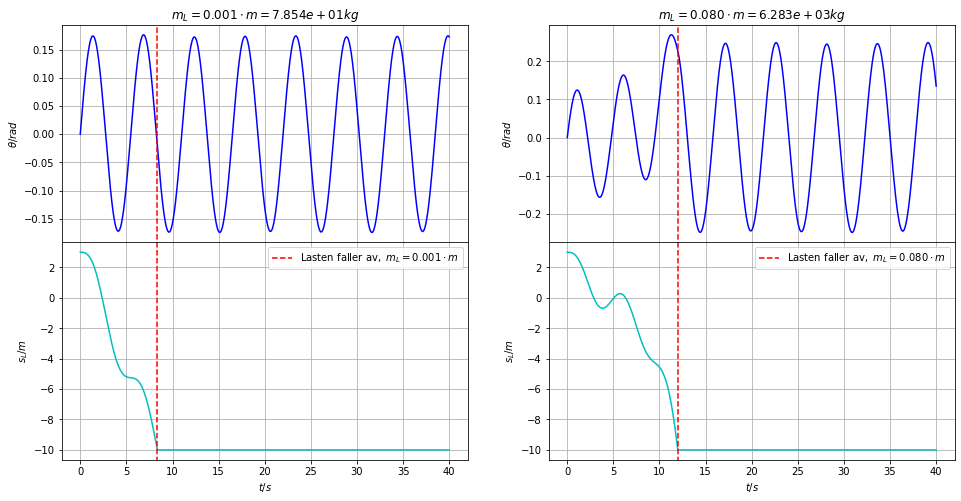

In [79]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2D(t, w_vec)

t0, tend = 0, 40

w0 = 0.2
theta0 = 0 *  np.pi/(180) # 20 grader, omgjort til radianer
vy0 = 0
x0 = 0
vx0 = 0
s_L = 3
v_L = 0
dt = 0.01

plt.subplots(2, 2, figsize=(16,8), gridspec_kw={"height_ratios":[5,3]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L_list = [0.001*m, 0.08*m]

for i, m_L in enumerate(m_L_list):
    beta_L = newtons_method(beta_fixed_L, del_beta_fixed, 1)
    y0 = get_y_C_0()
    w_vec = np.array([theta0, w0, y0, vy0, x0, vx0, s_L, v_L])

    t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)

    theta_num = w_vec_num[:,0]
    y_C_num = w_vec_num[:,2]
    x_C_num = w_vec_num[:,4]
    s_L_num = w_vec_num[:,6]

    # Plotter den numeriske y(t) 
    ax = plt.subplot(2, 2, i+1)
    ax.plot(t_num, theta_num, "b")
    if (np.abs(s_L_num) > R).any():
        fall_of_index = np.where((np.abs(s_L_num) > R))[0][0]
        ax.plot([t_num[fall_of_index], t_num[fall_of_index]], [-100, 100], "r--")

    ax.set_title(r"$m_L = %.3f \cdot m= %.3e kg$" % (m_L_list[i]/m, m_L_list[i]))
    ax.set_ylabel(r"$\theta/rad$")
    dtheta = np.amax(theta_num) - np.amin(theta_num)
    ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
    ax.grid()

    # Plottter den numeriske s_L(t)
    ax = plt.subplot(2, 2, i+3)
    ax.plot(t_num, s_L_num, "c")
    if (np.abs(s_L_num) > R).any():
        fall_of_index = np.where((np.abs(s_L_num) > R))[0][0]
        ax.plot([t_num[fall_of_index], t_num[fall_of_index]], [-100, 100], "r--", label=r"Lasten faller av, $\: m_{L} = %.3f \cdot m$" % (m_L_list[i]/m))
    ax.set_xlabel(r"$t/s$")
    ax.set_ylabel(r"$s_{L}/m$")
    ds_L = np.abs(np.amax(s_L_num) - np.amin(s_L_num))
    ax.set_ylim([np.amin(s_L_num) - ds_L/20, np.amax(s_L_num) + ds_L/20])
    ax.legend()
    ax.grid()

plt.show()

Her kan vi se at påvirkningen til den lille lasten på systemet og på skipets bevegelse er tilnærmet neglisjerbar, og lasten faller tidlig av. For den større lasten så vil momentet produsert før den faller av være av såpass størrelse, at vinkelutslaget blir klart større enn for den mindre lasten, og da også for skipet uten last. Det virker også som likevektslinjen til $\theta$ begynner å bli forskjøvet, men siden lasten til slutt faller av, og likevektslinjen forblir som tidligere.

Det er nok ikke urealistisk at skipet hadde gjerder som kunnne stoppet lasten fra å falle av. For å implementere gjerder legges det til endring i hva som skjer når $|s_L| > R$. Istedenfor å sette $m_L$ til 0, lar vi heller lasten sin hastighet bli 0 og bestemmer at lasten forblir på siden den traff gjerdet.

Under så plotter vi posisjonen til lasten $s_L$, $y_C$ og vinkelutslaget $\theta$ som funksjon av $t$ for $m_L = 0.001 \cdot m$ og $m_L = 0.08 \cdot m$, nå med gjerder. Initialbetingelsene vi bruker er:

$\begin{aligned}
    \theta &= 0 \:rad \\
    \omega &= 0.2 \:rad/s \\
    y &= y_C^0 \quad (\text{Gitt slik beskrevet over}) \\
    v_y &= 0 \:m/s \\
    x &= 0 \:m \\
    v_x &= 0 \:m/s \\
    s_L &= 3 \:m = 3R/10 \\
    v_L &= 0 \:m/s
\end{aligned}$

In [80]:
def f_oppgave_2E(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    global m_L
    tau_array = np.array([tau_B, tau_L])
    Fy_array = np.array([F_G, F_B, F_Ly])
    Fx_array = np.array([F_Lx])
    FL_array = np.array([F_GL])
    f_vec = np.zeros_like(w_vec)
    if np.abs(w_vec[6]) > R:
        pass
    else:
        f_vec[6] = w_vec[7]
        f_vec[7] = np.sum([FL(t, w_vec) for FL in FL_array]) / m_L
    
    f_vec[0] = w_vec[1]
    f_vec[1] = np.sum([tau(t, w_vec) for tau in tau_array]) / I_c
    f_vec[2] = w_vec[3]
    f_vec[3] = np.sum([Fy(t, w_vec) for Fy in Fy_array])/ m
    f_vec[4] = w_vec[5]
    f_vec[5] = np.sum([Fx(t, w_vec) for Fx in Fx_array])/ m

    return f_vec

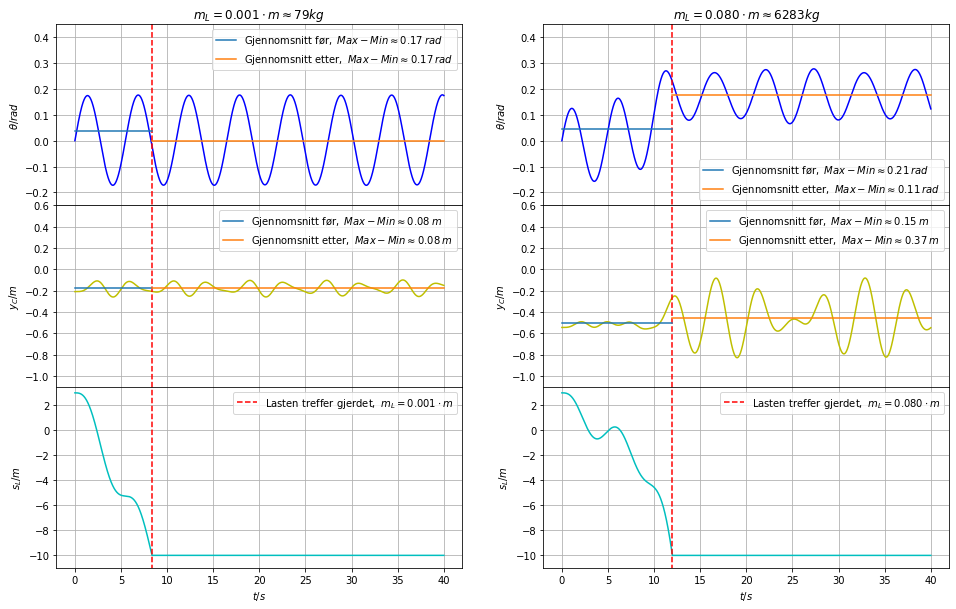

In [81]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2E(t, w_vec)
t0, tend = 0, 40

w0 = 0.2
theta0 = 0 *  np.pi/(180) # 20 grader, omgjort til radianer
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
s_L = 3
v_L = 0
dt = 0.01

plt.subplots(3, 2, figsize=(16,10), gridspec_kw={"height_ratios":[5, 3, 2]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L_list = [0.001*m, 0.08*m]

for i, m_L in enumerate(m_L_list):
    beta_L = newtons_method(beta_fixed_L, del_beta_fixed, 1)
    y0 = get_y_C_0()
    w_vec = np.array([theta0, w0, y0, vy0, x0, vx0, s_L, v_L])

    t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)

    theta_num = w_vec_num[:,0]
    y_C_num = w_vec_num[:,2]
    x_C_num = w_vec_num[:,4]
    s_L_num = w_vec_num[:,6]

    # Plotter den numeriske theta(t) 
    ax = plt.subplot(3, 2, i+1)
    ax.plot(t_num, theta_num, "b")
    if (np.abs(s_L_num) > R).any():
        fall_of_index = np.where((np.abs(s_L_num) > R))[0][0]
        ax.plot([t_num[fall_of_index], t_num[fall_of_index]], [-100, 100], "r--")
        theta_equil0 = np.mean(theta_num[:fall_of_index])
        theta_equil1 = np.mean(theta_num[fall_of_index:])
        Atheta0 = (np.amax(theta_num[:fall_of_index]) - np.amin(theta_num[:fall_of_index]))/2
        Atheta1 = (np.amax(theta_num[fall_of_index:]) - np.amin(theta_num[fall_of_index:]))/2
        ax.plot([t_num[0], t_num[fall_of_index-1]], [theta_equil0, theta_equil0], label=r"Gjennomsnitt før, $\: Max-Min \approx %.2f \: rad$" % Atheta0)
        ax.plot([t_num[fall_of_index], t_num[-1]], [theta_equil1, theta_equil1], label=r"Gjennomsnitt etter, $\: Max-Min \approx %.2f \: rad$" % Atheta1)

    ax.set_title(r"$m_L = %.3f \cdot m \approx %.0f kg$" % (m_L_list[i]/m, np.round(m_L_list[i])))
    ax.set_ylabel(r"$\theta/rad$")
    dtheta = np.amax(theta_num) - np.amin(theta_num)
    # ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
    ax.set_ylim([-0.25, 0.45])
    ax.legend()
    ax.grid()

    # Plotter den numeriske y(t) 
    ax = plt.subplot(3, 2, i+3)
    ax.plot(t_num, y_C_num, "y")
    if (np.abs(s_L_num) > R).any():
        fall_of_index = np.where((np.abs(s_L_num) > R))[0][0]
        ax.plot([t_num[fall_of_index], t_num[fall_of_index]], [-100, 100], "r--")
        y_equil0 = np.mean(y_C_num[:fall_of_index])
        y_equil1 = np.mean(y_C_num[fall_of_index:])
        Ay0 = (np.amax(y_C_num[:fall_of_index]) - np.amin(y_C_num[:fall_of_index]))/2
        Ay1 = (np.amax(y_C_num[fall_of_index:]) - np.amin(y_C_num[fall_of_index:]))/2
        ax.plot([t_num[0], t_num[fall_of_index-1]], [y_equil0, y_equil0], label=r"Gjennomsnitt før, $\: Max-Min \approx %.2f \: m$" % Ay0)
        ax.plot([t_num[fall_of_index], t_num[-1]], [y_equil1, y_equil1], label=r"Gjennomsnitt etter, $\: Max-Min \approx %.2f \: m$" % Ay1)

    ax.set_ylabel(r"$y_{C}/m$")
    dy = np.amax(y_C_num) - np.amin(y_C_num)
    # ax.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
    ax.set_ylim([-1.1, 0.6])
    ax.legend()
    ax.grid()

    # Plottter den numeriske s_L(t)
    ax = plt.subplot(3, 2, i+5)
    ax.plot(t_num, s_L_num, "c")
    if (np.abs(s_L_num) > R).any():
        fall_of_index = np.where((np.abs(s_L_num) > R))[0][0]
        ax.plot([t_num[fall_of_index], t_num[fall_of_index]], [-100, 100], "r--", label=r"Lasten treffer gjerdet, $\: m_{L} = %.3f \cdot m$" % (m_L_list[i]/m))
    ax.set_xlabel(r"$t/s$")
    ax.set_ylabel(r"$s_L/m$")
    ds_L = np.abs(np.amax(s_L_num) - np.amin(s_L_num))
    # ax.set_ylim([np.amin(s_L_num) - ds_L/20, np.amax(s_L_num) + ds_L/20])
    ax.set_ylim([-11, 3.5])
    ax.legend()
    ax.grid()

plt.show()

På samme vis som for uten gjerder, virker det som at den lille lasten nesten ikke påvirker vinkelutslaget eller likevektslinjen til $\theta$, selv med gjerder. Dette er ikke overraskende, siden $m_L = 0.001 \cdot m$ vil være neglisjerbar i forhold til massen til hele skipet. Derimot for den større lasten blir vinkelutslaget mindre og likevektslinjen er klart forskjøvet. Dette stemmer med intuisjon, når vi øker avstanden til en delmasse fra det originale massesenteret så vil vi ha bevaring av dreieimpuls, som medfører at vinkelhastighet og vinkelutslaget må bli lavere. Massesenteret til skipet og lasten kombinert vil nå også være klart forskjellig fra likevekt på grunn av den økede avstanden til delmassen, som gir en forklaring til at likevektlinjen til $y$ og $\theta$ blir forskjøvet.

Siden det ikke virker krefter fra vind, havbølger og friksjon ennå, forventes det at energien til modellen skal være tilnærmet bevart. Derfor må energitapet til rotasjons bevegelsen bli omgjort til en annen form. Dette kan sees ved at utslaget til $y_C$ er blitt klart større etter lasten har festet seg til gjerdet.

For å gjøre modellen vår mer virkelightsnær er det klart at konsepter som friksjon fra havet, og harmoniske krefter fra både hav og vind bør inkluderes. Friksjon modelleres som en kraft som virker på grenseflaten mellom skipsbunnen og havet. For å forenkle friksjonskraften har vi satt den til å være proposjonal med arealet av skipets grenseflate mot vannet. Friksjonskraften får uttrykket: 

$\begin{aligned}
    f=-k_f R \gamma \omega 
\end{aligned}$

der $k_f$ er firksjonskonstant, $R$ er radiusen til skipet, $\gamma$ er vinkelen mellom vannstandene på båten, og $\omega$ er vinkelhastigheten. Friksjonskraften har angrepspunkt i skipets dypeste punkt $D$.

Den andre ytre kraften som blir lagt til er en ytre harmonisk kraft. Denne kraften skal simulere vind og bølger som treffer båten. Utrykket for den harmoniske kraften er:

$\begin{aligned}
    F_w(t)=F_0cos \omega_w t
\end{aligned}$

der $F_0$ er amplituden på kraften og  $\omega_w$ er frekvensen til den harmoniske kraften. Denne kraften har sitt angrepspunkt i vannoverflaten ved $y = 0$.

De to ytre kreftene vil også gi bidrag til dreiemoment om $C$:

$\begin{aligned}
    \tau_f=(y_C-(R(cos(\gamma/2))-1))  
\end{aligned}$

$\begin{aligned}
    \tau_w=F_w y_C  
\end{aligned}$

In [82]:
F_0 = 0
omega_W = 5
k_f = 0.5

def F_f(t, w_vec):     # friksjonskraft
    global k_f
    return -k_f*R*gamma(w_vec)*w_vec[1]

def F_W(t, w_vec):
    return F_0 * np.cos(omega_W*t) #med angrepspunkt høyde med vannlinja, y=0

def tau_f(t, w_vec):   #dreiemomentet til friksjonskraften
    return F_f(t, w_vec) * (w_vec[2] - R * (np.cos(gamma(w_vec)/2) - 1))

def tau_W(t,w_vec):  # dreiemomentet til 
    return F_W(t, w_vec)*w_vec[2]

def f_oppgave_2F(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    global m_L
    tau_array = np.array([tau_B, tau_f, tau_W])
    Fy_array = np.array([F_G, F_B])
    Fx_array = np.array([F_f, F_W])
    f_vec = np.zeros_like(w_vec)
    
    f_vec[0] = w_vec[1]
    f_vec[1] = np.sum([tau(t, w_vec) for tau in tau_array]) / I_c
    f_vec[2] = w_vec[3]
    f_vec[3] = np.sum([Fy(t, w_vec) for Fy in Fy_array])/ m
    f_vec[4] = w_vec[5]
    f_vec[5] = np.sum([Fx(t, w_vec) for Fx in Fx_array])/ m

    return f_vec

No handles with labels found to put in legend.
No handles with labels found to put in legend.


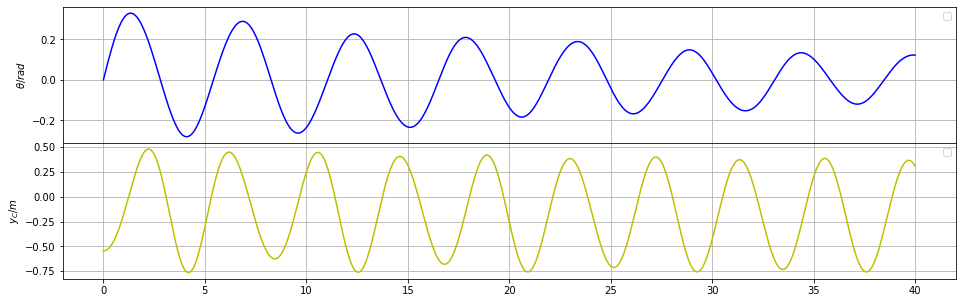

In [83]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2F(t, w_vec)

t0, tend = 0, 40

w0 = 0.4
omega_W = 0.93*np.sqrt(m*g*h/I_c)
theta0 = 0 *  np.pi/(180) # 20 grader, omgjort til radianer
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
s_L = 3
v_L = 0
F_0 = 0
k_f = 1000
dt = 0.01

plt.subplots(2, 1, figsize=(16,5), gridspec_kw={"height_ratios":[5, 5]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L = 0

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0, s_L, v_L])

t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]
s_L_num = w_vec_num[:,6]

# Plotter den numeriske theta(t) 
ax = plt.subplot(2, 1, 1)
ax.plot(t_num, theta_num, "b")

ax.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
# ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax.legend()
ax.grid()

# Plotter den numeriske y(t) 
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, y_C_num, "y")

ax.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax.legend()
ax.grid()

Ovenfor er det simulert et skip uten last og krefter harmoniske fra bølger og vind, men hvor friksjonen til vannet er tatt i betraktning. Det resulterer i en dempet svingning, i og med at friksjon alltid virker mot fartsretningen. Det vi observerer i plottet er akkurat det vi ville forventet for en fysisk pendel som har friksjon med omgivelsene. Amplituden til vinkelutslaget $\theta$ blir mindre og mindre ettersom friksjonen minker den totale energien i systemet over tid.

No handles with labels found to put in legend.


18.57244896888733


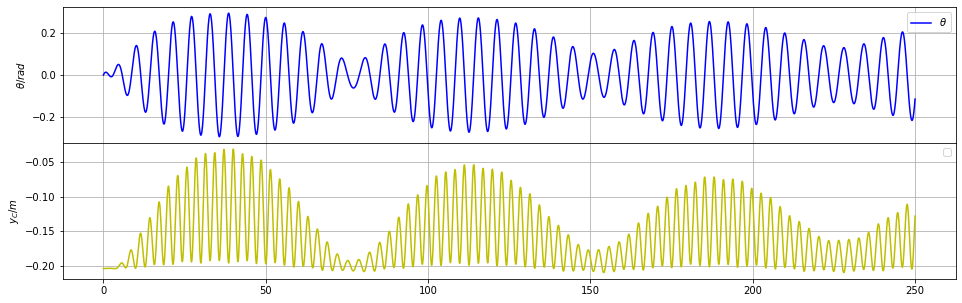

In [84]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2F(t, w_vec)

t0, tend = 0, 250

w0 = 2 * np.pi/(180) # 2 grader/s i rad/s
omega_W = 0.93*np.sqrt(m*g*h/I_c)
theta0 = 0 
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
F_0 = 0.625*m*g
k_f = 100
dt = 0.01

plt.subplots(2, 1, figsize=(16,5), gridspec_kw={"height_ratios":[5, 5]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L = 0

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])

start_tid = time.time()

t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)

print(time.time() - start_tid)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]

# Plotter den numeriske theta(t) 
ax = plt.subplot(2, 1, 1)
ax.plot(t_num, theta_num, "b", label=r"$\theta$")

ax.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax.legend()
ax.grid()

# Plotter den numeriske y(t) 
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, y_C_num, "y")

ax.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax.legend()
ax.grid()



Ovenfor er det simulert et system med liten friksjon, men med en stor harmonisk kraft virkende på skipet med en frekvens $\omega_w$ som er nesten lik egenfrekvensen til skipet. Denne relasjonen mellom kraftens frekvens og skipets egenfrekvens, fører til at vi opplever svevning, hvor både massesenteret og vinkelutslaget $\theta$ oscillerer mellom sine maksimale og minimale verdier.Sveving forekommer når to bølger med nesten samme frekvens møtes, og de på noen punkter danner konstruktiv interferens og andre punkter destruktiv interferens. Vi observerer også at $\theta$ divergerer, og tror dette oppstår på grunn av skipets gjenopprettende kraft og forstyrrelser i systemet. 

Nå som modellen begynner å bli mer sammensatt kan det nå være interessant å se på hvordan selv en liten harmonisk kraft kunne ført til at skipet kantret. Siden dette er simuleringer som skal kjøres fram til gjerne $t_{end}=250s$, og gjerne flere ganger, vil det nå være ønskelig med en numerisk metode som har kortere kjøretid. En ulemp ved Runge Kutta 4 er hvor lang tid det tar å kjøre, i forhold til andre metoder. Derfor har vi valgt å implementere en adaptiv Bogacki-Shampine metode. 

Bogacki-Shampine er en tredje ordens metode som benytter seg av "First Same as Last" trikset, ofte forkortet til FSAL. Metoder som bruker FSAL bruker siste funksjonsevaluering i et steg som den første i neste steg, som fører til at den slipper å gjøre en funskjonsevaluering i hvert steg. Det har en positiv innvirkning på kjøretiden. Siden Bogacki-Shampine er av orden lavere enn Runge Kutta 4, har vi også valgt å gjøre metoden adaptiv. Adaptiv steglengde betyr at metoden velger å ikke godta steget hvis den lokale feilen er større enn en gitt toleranse, men prøver på nytt med en steglengde litt kortere enn den forrige. 

Nedenfor er adaptiv Bogacki-Shampine implementert.

In [85]:
def bogshamp_step(f, x, y, h, k1):
#     k1 = f(x, y)
    k2 = f(x + 1/2*h, y + h*1/2*k1)
    k3 = f(x + 3/4*h, y + h*(3/4*k2))
    
    y_next = y + h * (2/9*k1 + 1/3*k2 + 4/9*k3)
    x_next = x + h
    k4 = f(x_next, y_next)
    error_estimate = h*np.linalg.norm(5/72*k1 -1/12*k2 -1/9*k3 + 1/8*k4)
    
    return y_next, x_next, error_estimate, k4
    
def bogshamp(f, t0, tend, w0, dt0, tol, pessimist = 1):
    p = 2
    
    w_num = np.array([w0])
    t_num = np.array([t0])
    
    tn = t0
    wn = w0
    dt = dt0
    
    k1 = f(t0, w0)
    fevals = 1
    
    maxcall = 1000000
    ncall = 0
    
    while tn <  tend - 1.e-10:
        
        if tn + dt > tend:                   
            dt = tend - tn 
        
        w_try, t_try, error_estimate, k1_try = bogshamp_step(f, tn, wn, dt, k1)
        ncall += 1
        fevals += 3
        
        if error_estimate < tol:
            tn = t_try
            wn = w_try
            if wn[0] > (np.pi - gamma(wn))/2: # If the ship capsizes
                wn[0] = np.sign(w_num[-1, 0]) * np.pi/2
                wn[1:] = 0
                for tn in np.arange(tn, tend+dt0, dt0):
                    w_num = np.concatenate((w_num, np.array([wn])))
                    t_num = np.append(t_num, tn)
                break  
            
            k1 = k1_try
            t_num = np.append(t_num, tn)
            w_num = np.concatenate((w_num, np.array([wn])))

        dt = pessimist*(tol/error_estimate)**(1/(p+1))*dt
        
        if ncall > maxcall:
            print('Maximum number of method calls')
            return t_num, w_num
    # print(f'Number of function evals = {fevals:4d}')
    # print(f'Number of accepted steps = {len(t_num)-1:4d}')
    # print(f'Number of rejected steps = {ncall-len(t_num)+1:4d}')
    return t_num, w_num

0.7466597557067871
20.110295057296753
Tiden til Bogacki-Shampine/RK4= 0.03712823474640525


C:\Users\lasse\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lasse\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


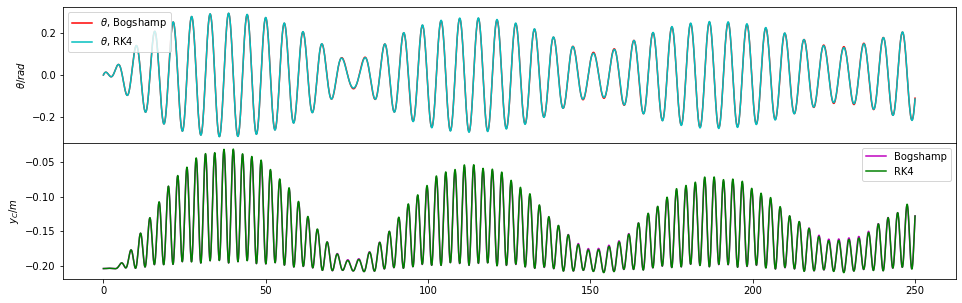

In [86]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2F(t, w_vec)

t0, tend = 0, 250

w0 = 2 * np.pi/(180) # 2 grader/s i rad/s
omega_W = 0.93*np.sqrt(m*g*h/I_c)
theta0 = 0 
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
F_0 = 0.625*m*g
k_f = 100
dt = 0.01

plt.subplots(2, 1, figsize=(16,5), gridspec_kw={"height_ratios":[5, 5]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L = 0

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])

start_tid = time.time()
t_num, w_vec_num = bogshamp(get_f_vector, t0, tend, w_vec, dt, tol=1e-3, pessimist=0.8)
time_bog = time.time() - start_tid
print(time_bog)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]

# Plotter den numeriske theta(t), bog
ax = plt.subplot(2, 1, 1)
ax.plot(t_num, theta_num, "r", label=r"$\theta$, Bogshamp")

ax.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax.legend()
ax.grid()

# Plotter den numeriske y(t), b
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, y_C_num, "m", label="Bogshamp")

ax.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax.legend()
ax.grid()

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])

start_tid = time.time()

t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)
time_rk4= time.time() - start_tid
print(time_rk4)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]

# Plotter den numeriske theta(t) 
ax = plt.subplot(2, 1, 1)
ax.plot(t_num, theta_num, "c", label=r"$\theta$, RK4")

ax.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
ax.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax.legend()
ax.grid()

# Plotter den numeriske y(t) 
ax = plt.subplot(2, 1, 2)
ax.plot(t_num, y_C_num, "g", label="RK4")

ax.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax.legend()
ax.grid()

print(f'Tiden til Bogacki-Shampine/RK4= {time_bog/time_rk4}')

Ovenfor er det samme systemet som vi først observerte svening simulert igjen, men nå med både Runge kutta og med den nylig implementerte adaptive Bogshamp metoden. Som det er mulig å se fra plottet er løsingen fra Bogacki-Shampine og fra Runge Kutta er nesten ikke mulig å skille. En ulempe med Bogacki-Shampine i forhold til Runge Kutta 4 er at feilen er større men vi konkluderer ut i fra plottet at Bogacki-Shampine vil fungere godt nok for vårt kvantitative forsøk. Videre er også har vi også funnet at kjøretiden til Bogacki-Shampine som regel er rundt 5% av kjøretiden til Runge Kutta 4, som er betydelig for større kalkulasjoner. I et kvantitativt forsøk som vi vil gjennomføre senere er tidsdifferansen såpass stor at det er viktigere enn forskjellen i feilen. Oppsummert vil Runge Kutta 4 være den best egnede løseren for simple utregninger som krever presise svar, mens adaptiv Bogacki-Shampine vil være best for kvantitative undersøkelser som krever mange utregninger. 

Tilbake til spørsmålet om en liten harmonisk kraft kunne ha fått Vasa-skipet til å kantre. Resonansfrekvens er et kjent begrep innenfor brobygging, og er grunnen til flere store ulykker gjennom de siste århundre. Noen typer broer har en egenfrekvens som gjør at vind som kommer i bølger kan kohere og danne store utslag, som til sutt er så store at broen faller sammen. Dette vil være et fenomen som også kan forkomme for vår skipsmodell. Vi ønsker å undersøke hvor stort intervall rundt egenfrekvensen til skipet dette kan være et problem. 

Systemet vi har valgt å undersøke har en harmonisk kraft av størrelse mindre størrelse enn tidligere. Friksjonskraften er ikke sløyfet, men ikke for stor til at det ikke er mulig for båten å kantre. Videre har vi gjennomført simuleringer med frekvensen til den harmoniske kraften på intervallet $[0.98\cdot\omega_0, 1.02\cdot\omega_0]$ med 0.001 intervaller, og sett for hvilke av disse verdiene for frekvens skipet kantrer.

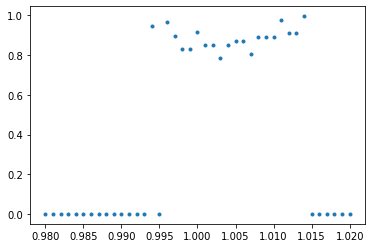

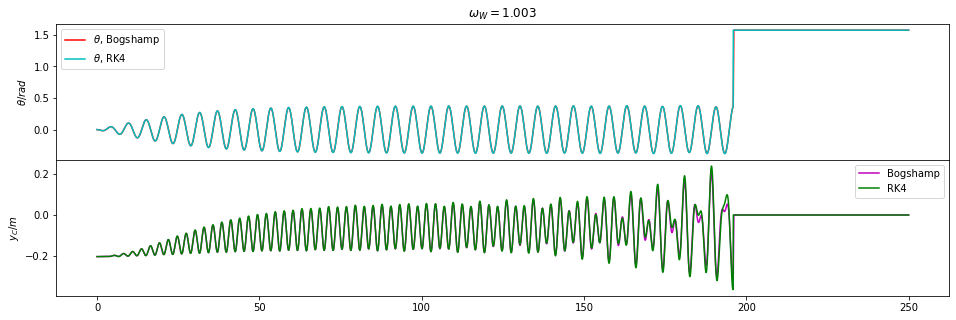

In [87]:
def get_f_vector(t, w_vec):
    '''
    f_vec = [w, del_w, v_y, a_y, v_x, a_x, v_L, a_L]^T
    '''
    return f_oppgave_2F(t, w_vec)
     

t0, tend = 0, 250

m_L = 0

w0 = 0
omega_W = np.sqrt(m*g*h/I_c)
omega_W_array = omega_W * np.arange(0.98, 1.02, 0.001)
theta0 = 0 
y0 = get_y_C_0()
vy0 = 0
x0 = 0
vx0 = 0
F_0 = 0.4*m*g
k_f = 10
dt = 0.01

m_L = 0
min_omega_w = 100
min_omega_w_index = 0

kantrer_bool_array = np.zeros_like(omega_W_array)
for i, omega_W in enumerate(omega_W_array):
    w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])
    t_num, w_vec_num = bogshamp(get_f_vector, t0, tend, w_vec, dt, tol=1e-3, pessimist=0.8)

    if np.abs(w_vec_num[-1,0]) == np.pi/2:
        kantrer_bool_array[i] = t_num[np.where(w_vec_num[:,0]==np.pi/2)[0][0]] / tend
        if kantrer_bool_array[i] < kantrer_bool_array[min_omega_w_index] or kantrer_bool_array[min_omega_w_index] == 0:
            min_omega_w_index = i
            min_omega_w = omega_W
    else:
        kantrer_bool_array[i] = 0

plt.plot(omega_W_array / np.sqrt(m*g*h/I_c), kantrer_bool_array, ".")
plt.show()

omega_W = min_omega_w


plt.subplots(2, 1, figsize=(16,5), gridspec_kw={"height_ratios":[5, 5]}, sharex="col")
plt.subplots_adjust(hspace=0)

m_L = 0

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])

t_num, w_vec_num = bogshamp(get_f_vector, t0, tend, w_vec, dt, tol=1e-3, pessimist=0.8)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]

# Plotter den numeriske theta(t), bog
ax1 = plt.subplot(2, 1, 1)
ax1.set_title(r"$\omega_W = %.3f$" % (omega_W/np.sqrt(m*g*h/I_c)))
ax1.plot(t_num, theta_num, "r", label=r"$\theta$, Bogshamp")

ax1.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
ax1.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax1.legend()
ax1.grid()

# Plotter den numeriske y(t), b
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t_num, y_C_num, "m", label="Bogshamp")

ax2.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax2.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax2.legend()
ax2.grid()

w_vec = np.array([theta0, w0, y0, vy0, x0, vx0])

t_num, w_vec_num = ODE_solver(get_f_vector, t0, tend, w_vec, dt, RK4)

theta_num = w_vec_num[:,0]
y_C_num = w_vec_num[:,2]
x_C_num = w_vec_num[:,4]

# Plotter den numeriske theta(t) 
ax1.plot(t_num, theta_num, "c", label=r"$\theta$, RK4")

ax1.set_ylabel(r"$\theta/rad$")
dtheta = np.amax(theta_num) - np.amin(theta_num)
ax1.set_ylim([np.amin(theta_num) - dtheta/20, np.amax(theta_num) + dtheta/20])
ax1.legend()
ax1.grid()

# Plotter den numeriske y(t) 
ax2.plot(t_num, y_C_num, "g", label="RK4")

ax2.set_ylabel(r"$y_{C}/m$")
dy = np.amax(y_C_num) - np.amin(y_C_num)
ax2.set_ylim([np.amin(y_C_num) - dy/20, np.amax(y_C_num) + dy/20])
ax2.legend()
ax2.grid()

Vi observerer at modellen bruker svært lang tid på å kantre, men virker som å ha nådd et største mulig vinkelutslag ganske tidlig, men trenger den samme sammenhengen mellom lavt massesenter og maks vinkelutslag på en gang for å kantre som tidligere observert. Vi ser også skipet kantrer for $\omega_W$ verdier i en område rundt den forventede egenfrekvensen. Hvis den harmonisk kraften hadde vært større eller vi kjørte simuleringene i lengre, så kunne kanskje enda flere frekvenser ført til at skipet hadde kantret. Uansett så kan det klart sees fra simuleringene våre at modellen vår er svært sensitiv harmoniske krefter som ligger seg nær egenfrekvensen til båten. 

For å forsikre oss selv om at bogshamp ikke førte stort tap av presisjon, har vi plottet RK4 og Bogshamp simuleringene for frekvensen som førte til den kantret tidligst. For vinkelutslaget er det vanskelig å se forskjell. På $y_C$ plottet virker det som noe ulike tallverdier, men det ser ikke ut som noen altfor store gap. Med tanke på at begge to kantrer samtidig så vil vi argumentere for at Bogshamp var et godt alternativ til RK4 her, for å redusere kjøretiden betraktelig.

Selv om er modellen vår ganske enkel i natur, og vi ser vekk i fra mye fluidmekanikk og annen kompliserte dynamikker som man selvsagt finner i virkeligheten, så vil vi argumentere for at modellene våre kan gi litt innsikt i mulige årsaker til Vasa-skipet kantret. Dette kan være årsaker som last på dekk eller ytre harmoniske krefter. Begge har ført til kantring alene i modellen vår, men på det ekte skipet var det nok en kombinasjon av begge deler og muligens flere andre årsaker i tillegg som førte til at skipet kantret.